In [1]:
# ok maybe we just quasi-randomly sample mix rates, then can plot countor 

# do this for all the toy datasets and waterbirds 

# later we can do it for celebA-0 and multi-nli with mix rate 0.5 

In [1]:
import os 
os.chdir("/nas/ucb/oliveradk/diverse-gen/")

In [2]:
from itertools import product
from pathlib import Path
from datetime import datetime
import copy

import optuna
import numpy as np

from losses.loss_types import LossType
from utils.exp_utils import get_study_args_dict, get_executor, run_experiments
from run_study import get_storage_path

/nas/ucb/oliveradk/miniforge3/envs/od_3_10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
N_TRIALS = 120
NODES_PER_STUDY = 12 # NOTE: this should be 13 but oh well
SAMPLER = "quasi-random"
STUDY_SCRIPT_NAME = "run_study.py"

SCRIPT_NAME = "spur_corr_exp.py"
HPARM_PARENT_DIR = Path("output/cc_mix_rate_lower_bound_sweep")
HPARAM_DIR_NAME = None

if HPARAM_DIR_NAME is None:
    hparam_dir_name = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
    hparam_dir = Path(HPARM_PARENT_DIR, hparam_dir_name)
    hparam_dir.mkdir(exist_ok=True, parents=True)
else:
    hparam_dir = Path(HPARM_PARENT_DIR, HPARAM_DIR_NAME)

In [4]:

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def plot_partitions(partitions):
    # Plot each partition as a filled rectangle
    for partition in partitions:
        x_min, y_min, x_max, y_max = partition
        width = x_max - x_min
        height = y_max - y_min
        
        # Create rectangle patch
        rect = Rectangle(
            (x_min, y_min),  # (x,y) of lower-left corner
            width,           # width
            height,         # height
            fill=True,
            alpha=0.2,      # transparency
            edgecolor='black',
            facecolor='gray'
        )
        
        # Add rectangle to plot
        plt.gca().add_patch(rect)

    # Add diagonal line x + y = 1
    x = np.linspace(0, 1, 100)
    y = 1 - x
    plt.plot(x, y, 'r--', label='x + y = 1')

    plt.xlabel('Mix Rate Lower Bound 01')
    plt.ylabel('Mix Rate Lower Bound 10')
    plt.title('Partition Regions')
    plt.grid(True, alpha=0.2)
    plt.axis('equal')
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.legend()
    plt.show()

In [5]:
MIX_RATES = [0.1, 0.25, 0.5, 0.75, 1.0]

# using aux weight 1.0 for now

# TODO: add linear schedule

env_configs = {
    "toy_grid": {"dataset": "toy_grid", "model": "toy_model", "epochs": 100, "batch_size": 32, "target_batch_size": 128, "lr": 1e-3, "optimizer": "sgd"},
    "fmnist_mnist": {"dataset": "fmnist_mnist", "model": "Resnet50", "epochs": 5},
    "cifar_mnist": {"dataset": "cifar_mnist", "model": "Resnet50", "epochs": 5},
    "waterbirds": {"dataset": "waterbirds", "model": "Resnet50", "epochs": 5},
#     "celebA-0": {"dataset": "celebA-0", "model": "Resnet50", "epochs": 5},
#     "multi-nli": {"dataset": "multi-nli", "model": "bert", "epochs": 1, "lr": 1e-5, "combine_neut_entail": True, "contra_no_neg": True},
}


hparam_map = {
    "mix_rate_lower_bound_01": {"type": "float", "range": [0, 1], "log": False},
    "mix_rate_lower_bound_10": {"type": "float", "range": [0, 1], "log": False},
}

# PARTITIONS = [
#     [0, 0, 0.25, 0.5], 
#     [0.25, 0, 0.5, 0.5], 
#     [0, 0.5, 0.25, 1], 
#     [0.25, 0.5, 0.5, 1], 
#     [0.5, 0, 0.75, 0.5], 
#     [0.75, 0.0, 1.0, 0.5], 
# ]

PARTITIONS = [
    # Bottom row (left to right)
    [0.0, 0.0, 0.25, 0.25],
    [0.25, 0.0, 0.5, 0.25],
    [0.5, 0.0, 0.75, 0.25],
    [0.75, 0.0, 1.0, 0.25],
    
    # Second row
    [0.0, 0.25, 0.25, 0.5],
    [0.25, 0.25, 0.5, 0.5],
    [0.5, 0.25, 0.75, 0.5],
    [0.75, 0.25, 1.0, 0.5],
    
    # Third row
    [0.0, 0.5, 0.25, 0.75],
    [0.25, 0.5, 0.5, 0.75],
    [0.5, 0.5, 0.75, 0.75],
    # [0.75, 0.5, 1.0, 0.75],
    
    # Top row (excluding rightmost corner partitions)
    [0.0, 0.75, 0.25, 1.0],
    [0.25, 0.75, 0.5, 1.0],
    # [0.5, 0.75, 0.75, 1.0],
    # [0.75, 0.75, 1.0, 1.0],
]



def update_hparam_map(hparam_map, idx):
    new_hparam_map = copy.deepcopy(hparam_map)
    parition = PARTITIONS[idx]
    new_hparam_map["mix_rate_lower_bound_01"]["range"] = [parition[0], parition[2]]
    new_hparam_map["mix_rate_lower_bound_10"]["range"] = [parition[1], parition[3]]
    return new_hparam_map

configs = {}
for (env_name, env_config), mix_rate in product(env_configs.items(), MIX_RATES):
    configs[(env_name, mix_rate)] = {
        **env_config, 
        "mix_rate": mix_rate, 
        "loss_type": LossType.TOPK,
        "mix_rate_lower_bound": None, 
        "mix_rate_schedule": "linear", 
        "mix_rate_t0": 0, 
        "mix_rate_t1": env_config["epochs"]
    }

dataset_to_mem_gb = {
    "toy_grid": 16,
    "fmnist_mnist": 16,
    "cifar_mnist": 16,
    "waterbirds": 16,
    "celebA-0": 32,
    "multi-nli": 32,
}

def get_study_name(env_name, mix_rate):
    return f"{env_name}_{mix_rate}"


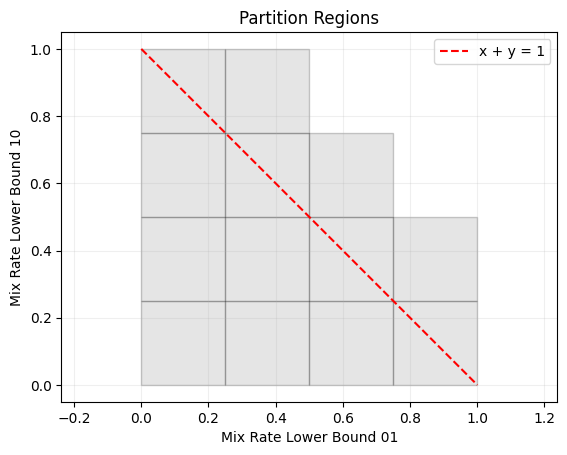

In [6]:
plot_partitions(PARTITIONS)

# Run Experiments

In [7]:
for (env_name, mix_rate), conf in configs.items(): 
    study_name = get_study_name(env_name, mix_rate)
    study_dir = Path(hparam_dir, study_name)
    study_dir.mkdir(exist_ok=True, parents=True)
    
    # create study (must create it here to nodes don't conflict)
    study = optuna.create_study(study_name=study_name, storage=get_storage_path(study_dir), direction="minimize", load_if_exists=True)  
    
    # run study
    n_trials_per_node = N_TRIALS // NODES_PER_STUDY
    cmds = [
        {
            **get_study_args_dict(conf, SCRIPT_NAME, update_hparam_map(hparam_map, i), n_trials_per_node, 0, study_name, study_dir), 
            "sampler_seed": i, 
            "sampler_type": SAMPLER
        } for i in range(NODES_PER_STUDY)
    ]
    executor = get_executor(study_dir, mem_gb=dataset_to_mem_gb[env_name], slurm_array_parallelism=NODES_PER_STUDY)

    jobs = run_experiments(executor, cmds, STUDY_SCRIPT_NAME)

[I 2025-02-04 07:49:50,495] A new study created in RDB with name: toy_grid_0.1
[I 2025-02-04 07:49:50,762] A new study created in RDB with name: toy_grid_0.25
[I 2025-02-04 07:49:50,916] A new study created in RDB with name: toy_grid_0.5
[I 2025-02-04 07:49:51,156] A new study created in RDB with name: toy_grid_0.75
[I 2025-02-04 07:49:51,314] A new study created in RDB with name: toy_grid_1.0
[I 2025-02-04 07:49:51,477] A new study created in RDB with name: fmnist_mnist_0.1
[I 2025-02-04 07:49:51,635] A new study created in RDB with name: fmnist_mnist_0.25
[I 2025-02-04 07:49:51,789] A new study created in RDB with name: fmnist_mnist_0.5
[I 2025-02-04 07:49:51,937] A new study created in RDB with name: fmnist_mnist_0.75
[I 2025-02-04 07:49:52,089] A new study created in RDB with name: fmnist_mnist_1.0
[I 2025-02-04 07:49:52,232] A new study created in RDB with name: cifar_mnist_0.1
[I 2025-02-04 07:49:52,383] A new study created in RDB with name: cifar_mnist_0.25
[I 2025-02-04 07:49:5

# Process Results

In [9]:
# load study 
hparam_dir = "output/cc_mix_rate_lower_bound_sweep/2025-02-03_15-03-47"

In [10]:
# so right now I want to do some exploratory analysis
# for example, for a given dataset and mix rate, plot the max source acc counter grid 
import json
import yaml
import pandas as pd
import numpy as np
# load all metrics in output/cc_mix_rate_lower_bound_sweep into a dataframe 
results = []
for study_dir in Path(hparam_dir).iterdir():
    if not study_dir.is_dir():
        continue
    for exp_dir in study_dir.iterdir():
        if not exp_dir.is_dir():
            continue
        if exp_dir.name == "0":
            continue
        metric_file = exp_dir / "metrics.json"
        config_file = exp_dir / "config.yaml"
        with open(metric_file, "r") as f:
            metrics = json.load(f)
        with open(config_file, "r") as f:
            config = yaml.safe_load(f)
        
        min_val_loss_idx = np.argmin(metrics["val_loss"])
        min_val_loss = metrics["val_loss"][min_val_loss_idx]

        source_acc_0 = metrics["val_source_acc_0"][min_val_loss_idx]
        source_acc_1 = metrics["val_source_acc_1"][min_val_loss_idx]
        max_source_acc = max(source_acc_0, source_acc_1)

        target_acc_0 = metrics["val_target_acc_0"][min_val_loss_idx]
        target_acc_1 = metrics["val_target_acc_1"][min_val_loss_idx]
        max_target_acc = max(target_acc_0, target_acc_1)

        test_acc_0 = metrics["test_acc_0"][min_val_loss_idx]
        test_acc_1 = metrics["test_acc_1"][min_val_loss_idx]
        max_test_acc = max(test_acc_0, test_acc_1)
        
       
        # Create a dictionary for each experiment
        result_dict = {
            'dataset': config["dataset"],
            'mix_rate': config["mix_rate"],
            'mix_rate_lb_01': config["mix_rate_lower_bound_01"],
            'mix_rate_lb_10': config["mix_rate_lower_bound_10"],
            'source_acc': max_source_acc,
            'target_acc': max_target_acc,
            'test_acc': max_test_acc,
            'study_dir': str(study_dir),
            'exp_dir': str(exp_dir)
        }
        results.append(result_dict)

df = pd.DataFrame(results)

In [11]:
df

,dataset,mix_rate,mix_rate_lb_01,mix_rate_lb_10,source_acc,target_acc,test_acc,study_dir,exp_dir
0,fmnist_mnist,0.25,0.500000,0.000000,1.000000,0.839844,0.644898,output/cc_mix_rate_lower_bound_sweep/2025-02-0...,output/cc_mix_rate_lower_bound_sweep/2025-02-0...
1,fmnist_mnist,0.25,0.046875,0.637416,0.937500,0.976562,0.966327,output/cc_mix_rate_lower_bound_sweep/2025-02-0...,output/cc_mix_rate_lower_bound_sweep/2025-02-0...
2,fmnist_mnist,0.25,0.269077,0.944980,0.820312,0.691406,0.763265,output/cc_mix_rate_lower_bound_sweep/2025-02-0...,output/cc_mix_rate_lower_bound_sweep/2025-02-0...
3,fmnist_mnist,0.25,0.301680,0.359375,0.964844,0.687500,0.779592,output/cc_mix_rate_lower_bound_sweep/2025-02-0...,output/cc_mix_rate_lower_bound_sweep/2025-02-0...
4,fmnist_mnist,0.25,0.137203,0.178797,0.976562,0.925781,0.940816,output/cc_mix_rate_lower_bound_sweep/2025-02-0...,output/cc_mix_rate_lower_bound_sweep/2025-02-0...
...,...,...,...,...,...,...,...,...,...
615,cifar_mnist,1.00,0.717299,0.187500,0.968750,0.812500,0.869388,output/cc_mix_rate_lower_bound_sweep/2025-02-0...,output/cc_mix_rate_lower_bound_sweep/2025-02-0...
616,cifar_mnist,1.00,0.000000,0.000000,1.000000,0.000000,0.500000,output/cc_mix_rate_lower_bound_sweep/2025-02-0...,output/cc_mix_rate_lower_bound_sweep/2025-02-0...
617,cifar_mnist,1.00,0.078125,0.637416,1.000000,0.718750,0.822449,output/cc_mix_rate_lower_bound_sweep/2025-02-0...,output/cc_mix_rate_lower_bound_sweep/2025-02-0...
618,cifar_mnist,1.00,0.108999,0.506482,1.000000,0.859375,0.918367,output/cc_mix_rate_lower_bound_sweep/2025-02-0...,output/cc_mix_rate_lower_bound_sweep/2025-02-0...


In [ ]:
# for a given dataset and mix rate, plot conter (with x, y being mix_rate_lb_01 and mix_rate_lb_10, value max source acc)


In [14]:
def plot_mix_rate_accuracy(df, dataset, mix_rate, figsize=(10, 8), vmin=0.5, vmax=1.0):
    """
    Plot scatter of max source accuracy for given dataset and mix rate.
    
    Args:
        df: DataFrame containing the results
        dataset: str, name of dataset to plot
        mix_rate: float, mix rate to plot
        figsize: tuple, size of the figure (width, height)
    """
    import matplotlib.pyplot as plt
    
    # Filter data for specific dataset and mix rate
    mask = (df['dataset'] == dataset) & (df['mix_rate'] == mix_rate)
    data = df[mask]
    
    if len(data) == 0:
        print(f"No data found for dataset={dataset} and mix_rate={mix_rate}")
        return
    
    plt.figure(figsize=figsize)
    
    # Create scatter plot
    scatter = plt.scatter(
        data['mix_rate_lb_01'], 
        data['mix_rate_lb_10'], 
        c=data['source_acc'],
        cmap='viridis',
        vmin=vmin,  # Set minimum value for color scale
        vmax=vmax,  # Set maximum value for color scale
        s=100  # Point size
    )
    
    # Add colorbar
    plt.colorbar(scatter, label='Max Source Accuracy')
    
    # Labels and title
    plt.xlabel('Mix Rate Lower Bound 01')
    plt.ylabel('Mix Rate Lower Bound 10')
    plt.title(f'Max Source Accuracy\nDataset: {dataset}, Mix Rate: {mix_rate}')
    
    plt.tight_layout()
    plt.show()

In [19]:
# TODO: get ERM mean and std 
mean_source_accs = {
    'celebA-0': 0.996,
    'cifar_mnist': 1.0,
    'fmnist_mnist': 1.0,
    'toy_grid': 0.999,
    'waterbirds': 0.984
}

std_source_accs = {
    'celebA-0': 0.0,
    'cifar_mnist': 0.0,
    'fmnist_mnist': 0.0,
    'toy_grid': 0.002,
    'waterbirds': 0.004
}

In [ ]:
df

In [20]:
# get instances where source acc is within one std of the mean 
# Create a function to filter runs within 1 std of ERM mean
def get_runs_within_std(df, dataset, mean_source_accs, std_source_accs):
    # Filter for specific dataset
    dataset_df = df[df['dataset'] == dataset]
    
    # Get mean and std for this dataset
    mean = mean_source_accs[dataset]
    std = std_source_accs[dataset]
    
    # Filter for runs within 1 std of mean
    mask = (dataset_df['source_acc'] >= mean - std) & (dataset_df['source_acc'] <= mean + std)
    within_std_df = dataset_df[mask]
    
    print(f"\nDataset: {dataset}")
    print(f"ERM Mean: {mean:.4f}")
    print(f"ERM Std: {std:.4f}")
    print(f"Total runs: {len(dataset_df)}")
    print(f"Runs within 1 std: {len(within_std_df)} ({100*len(within_std_df)/len(dataset_df):.1f}%)")
    
    # Group by mix_rate and show counts
    mix_rate_counts = within_std_df.groupby('mix_rate').size()
    print("\nRuns by mix_rate:")
    print(mix_rate_counts)
    
    return within_std_df

# Analyze each dataset
datasets = ['cifar_mnist', 'fmnist_mnist', 'toy_grid', 'waterbirds']
results_by_dataset = {}

for dataset in datasets:
    results_by_dataset[dataset] = get_runs_within_std(
        df, dataset, mean_source_accs, std_source_accs
    )


Dataset: cifar_mnist
ERM Mean: 1.0000
ERM Std: 0.0000
Total runs: 155
Runs within 1 std: 36 (23.2%)

Runs by mix_rate:
mix_rate
0.10     8
0.25     6
0.50     5
0.75     4
1.00    13
dtype: int64

Dataset: fmnist_mnist
ERM Mean: 1.0000
ERM Std: 0.0000
Total runs: 155
Runs within 1 std: 61 (39.4%)

Runs by mix_rate:
mix_rate
0.10     1
0.25     1
0.50    13
0.75    19
1.00    27
dtype: int64

Dataset: toy_grid
ERM Mean: 0.9990
ERM Std: 0.0020
Total runs: 155
Runs within 1 std: 19 (12.3%)

Runs by mix_rate:
mix_rate
0.10    4
0.25    3
0.50    4
0.75    3
1.00    5
dtype: int64

Dataset: waterbirds
ERM Mean: 0.9840
ERM Std: 0.0040
Total runs: 155
Runs within 1 std: 17 (11.0%)

Runs by mix_rate:
mix_rate
0.10    1
0.25    1
0.75    6
1.00    9
dtype: int64


In [27]:
def analyze_max_lb_by_mix_rate(df):
    # Add column for combined lower bounds
    df = df.copy()
    df['combined_lb'] = df['mix_rate_lb_01'] + df['mix_rate_lb_10']
    
    # Group by mix_rate and get row with max combined lower bound
    max_lb_instances = df.loc[df.groupby('mix_rate')['combined_lb'].idxmax()]
    
    # Sort by mix_rate for cleaner display
    max_lb_instances = max_lb_instances.sort_values('mix_rate')
    
    # Select relevant columns
    display_cols = ['mix_rate', 'mix_rate_lb_01', 'mix_rate_lb_10', 'combined_lb', 'source_acc']
    
    return max_lb_instances[display_cols]

print("Maximum Lower Bound Instances by Mix Rate for Each Dataset:")
for dataset, dataset_df in results_by_dataset.items():
    print(f"\n{dataset.upper()}")
    print("-" * 80)
    max_lb_results = analyze_max_lb_by_mix_rate(dataset_df)
    print(max_lb_results.to_string())

Maximum Lower Bound Instances by Mix Rate for Each Dataset:

CIFAR_MNIST
--------------------------------------------------------------------------------
     mix_rate  mix_rate_lb_01  mix_rate_lb_10  combined_lb  source_acc
338      0.10        0.473215        0.582995     1.056210         1.0
98       0.25        0.455307        0.578125     1.033432         1.0
151      0.50        0.455307        0.510424     0.965731         1.0
512      0.75        0.455307        0.510424     0.965731         1.0
594      1.00        0.763591        0.840385     1.603975         1.0

FMNIST_MNIST
--------------------------------------------------------------------------------
     mix_rate  mix_rate_lb_01  mix_rate_lb_10  combined_lb  source_acc
471      0.10        0.000000        0.750000     0.750000         1.0
0        0.25        0.500000        0.000000     0.500000         1.0
539      0.50        0.956070        0.491437     1.447507         1.0
347      0.75        0.962204        0.79

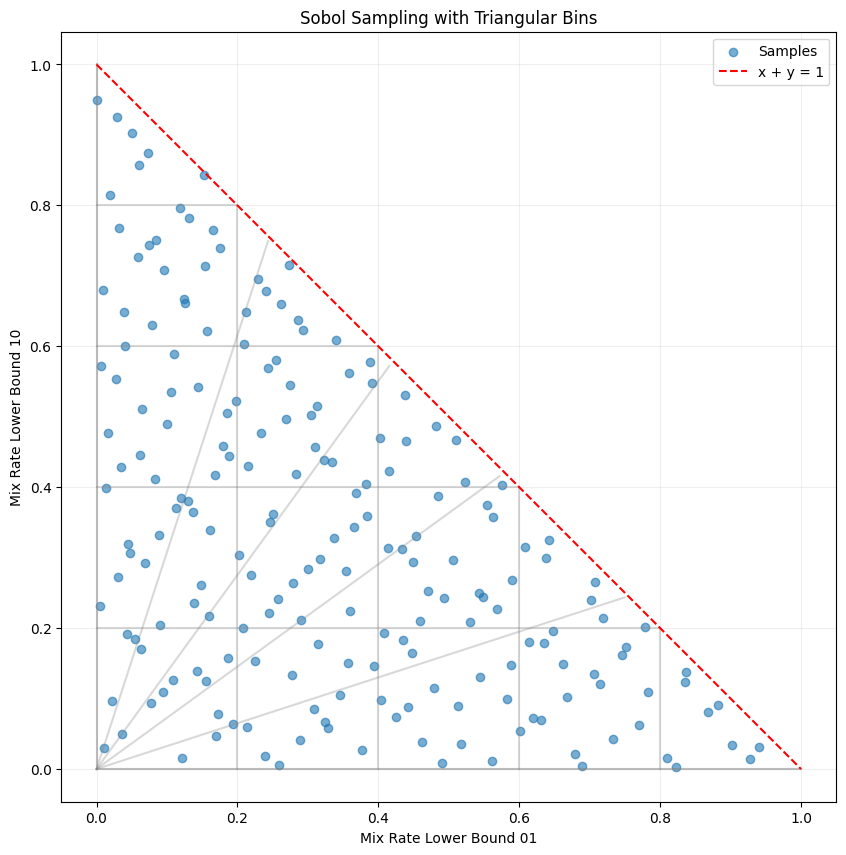


Points per triangular sector:
[[ 1  8 10 12 20]
 [ 0  3  5 12 10]
 [ 2  6  7 11  8]
 [ 1  3  7 10 17]
 [ 1  7 12 11 16]]


In [32]:
import numpy as np
from scipy.stats import qmc
import matplotlib.pyplot as plt

def generate_sobol_mix_rate_bounds(n_samples, max_sum=1.0):
    """
    Generate mix rate bounds using Sobol sequences for better space coverage
    """
    sampler = qmc.Sobol(d=2, scramble=True)
    # Generate more samples than needed since we'll filter some out
    samples = sampler.random(n=n_samples * 2)
    # Scale to [0, max_sum]
    samples *= max_sum
    # Filter points where sum <= max_sum
    valid_samples = samples[np.sum(samples, axis=1) <= max_sum]
    # Take only the first n_samples points
    return valid_samples[:n_samples]

def create_triangular_bins(n_bins=5):
    """
    Create bins that respect the triangular geometry where x + y <= 1
    """
    # Create diagonal lines parallel to x + y = 1
    diagonals = np.linspace(0, 1, n_bins+1)
    
    # Create radial lines from origin
    angles = np.linspace(0, np.pi/2, n_bins+1)
    
    return diagonals, angles

def plot_triangular_bins(diagonals, angles, samples):
    plt.figure(figsize=(10, 10))
    
    # Plot samples
    plt.scatter(samples[:, 0], samples[:, 1], alpha=0.6, label='Samples')
    
    # Plot diagonal lines (parallel to x + y = 1)
    for d in diagonals:
        x = np.linspace(0, 1-d, 100)
        y = d + np.zeros_like(x)
        plt.plot(x, y, 'gray', alpha=0.3)
        plt.plot(y, x, 'gray', alpha=0.3)
    
    # Plot radial lines from origin
    for angle in angles:
        r = np.linspace(0, 1, 100)
        x = r * np.cos(angle)
        y = r * np.sin(angle)
        # Clip the lines at x + y = 1
        mask = x + y <= 1
        plt.plot(x[mask], y[mask], 'gray', alpha=0.3)
    
    # Plot the constraint line x + y = 1
    x = np.linspace(0, 1, 100)
    y = 1 - x
    plt.plot(x, y, 'r--', label='x + y = 1')
    
    plt.xlabel('Mix Rate Lower Bound 01')
    plt.ylabel('Mix Rate Lower Bound 10')
    plt.title(f'Sobol Sampling with Triangular Bins')
    plt.legend()
    plt.grid(True, alpha=0.2)
    plt.axis('equal')
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.show()

# Generate samples
n_samples = 200
samples = generate_sobol_mix_rate_bounds(n_samples)

# Create and plot triangular bins
n_bins = 5
diagonals, angles = create_triangular_bins(n_bins)
plot_triangular_bins(diagonals, angles, samples)

# To count points in bins, we can use polar coordinates
def count_points_in_triangular_bins(samples, n_bins=5):
    # Convert to polar coordinates
    r = np.sqrt(samples[:, 0]**2 + samples[:, 1]**2)
    theta = np.arctan2(samples[:, 1], samples[:, 0])
    
    # Get sum of coordinates for diagonal binning
    coord_sum = samples[:, 0] + samples[:, 1]
    
    # Create bins
    r_bins = np.linspace(0, 1, n_bins+1)
    theta_bins = np.linspace(0, np.pi/2, n_bins+1)
    
    # Count points
    H, _, _ = np.histogram2d(theta, coord_sum, bins=[theta_bins, r_bins])
    return H.astype(int)

# Print number of points in each bin
print("\nPoints per triangular sector:")
H = count_points_in_triangular_bins(samples, n_bins)
print(H)

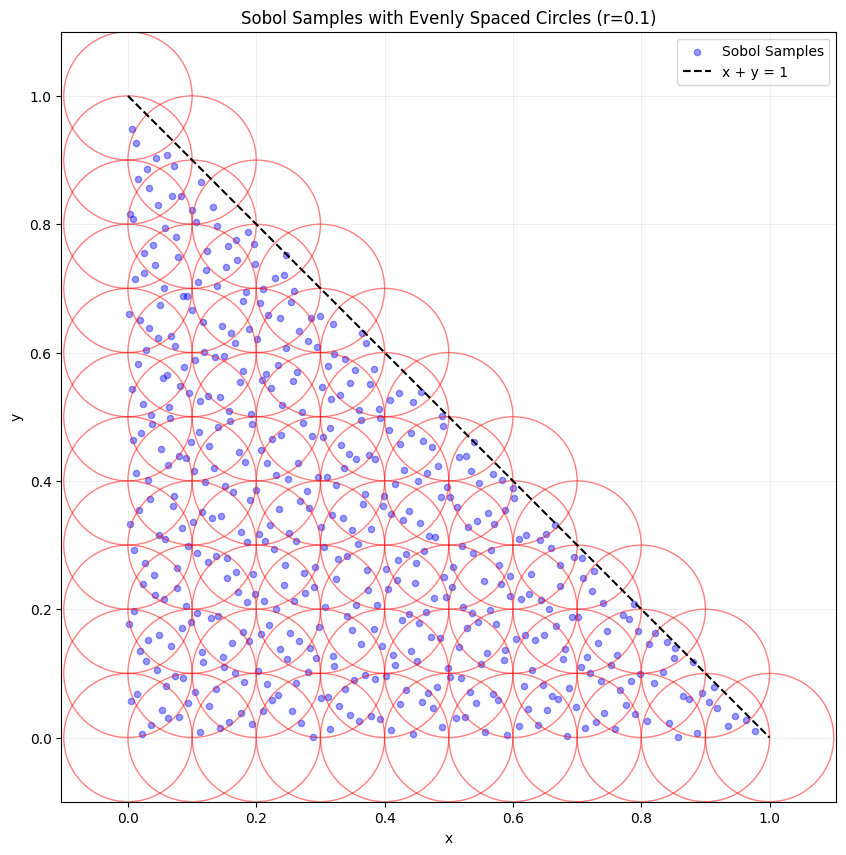

In [35]:
import numpy as np
from scipy.stats import qmc
import matplotlib.pyplot as plt

def generate_sobol_samples(n_samples, max_sum=1.0):
    """Generate Sobol samples within triangle where x + y <= 1"""
    sampler = qmc.Sobol(d=2, scramble=True)
    # Generate more samples than needed since we'll filter some out
    samples = sampler.random(n=n_samples * 2)
    # Scale to [0, max_sum]
    samples *= max_sum
    # Filter points where sum <= max_sum
    valid_samples = samples[np.sum(samples, axis=1) <= max_sum]
    # Take only the first n_samples points
    return valid_samples[:n_samples]

def create_circle_centers(spacing=0.1):
    """Create centers for circles in a grid pattern"""
    # Create grid of points
    x = np.arange(0, 1.1, spacing)
    y = np.arange(0, 1.1, spacing)
    centers = []
    for i in x:
        for j in y:
            if i + j <= 1:  # Only include points within triangle
                centers.append([i, j])
    return np.array(centers)

# Generate samples and circle centers
n_samples = 500
samples = generate_sobol_samples(n_samples)
centers = create_circle_centers(spacing=0.1)

# Create plot
plt.figure(figsize=(10, 10))

# Plot samples
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.4, label='Sobol Samples', color='blue', s=20)

# Plot circles
radius = 0.1
for center in centers:
    circle = plt.Circle(center, radius, fill=False, color='red', alpha=0.5)
    plt.gca().add_patch(circle)

# Plot constraint line x + y = 1
x = np.linspace(0, 1, 100)
y = 1 - x
plt.plot(x, y, 'k--', label='x + y = 1')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Sobol Samples with Evenly Spaced Circles (r=0.1)')
plt.legend()
plt.grid(True, alpha=0.2)
plt.axis('equal')
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 1.1)
plt.show()

Total samples: 500
Number of circles: 66
Mean samples per circle: 23.24
Std samples per circle: 8.50
Min samples per circle: 5
Max samples per circle: 33


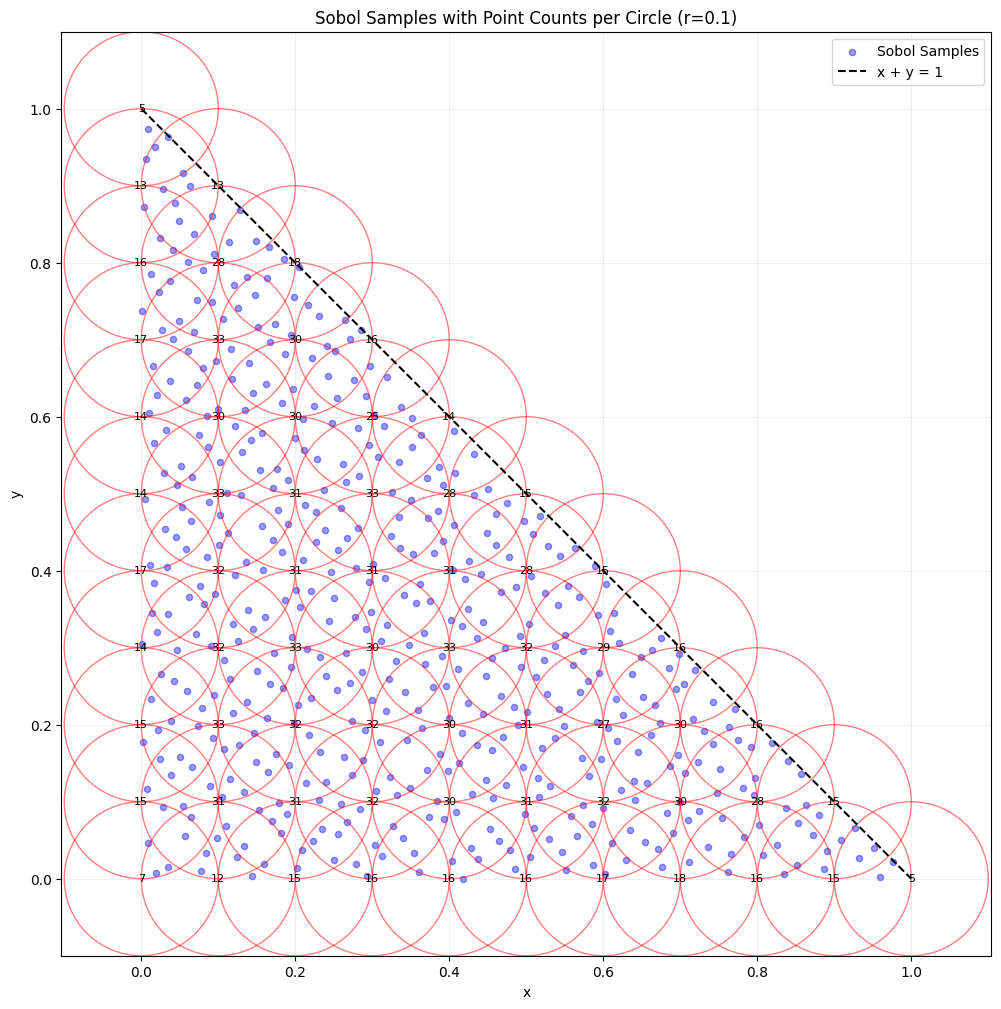

In [36]:
import numpy as np
from scipy.stats import qmc
import matplotlib.pyplot as plt

def generate_sobol_samples(n_samples, max_sum=1.0):
    """Generate Sobol samples within triangle where x + y <= 1"""
    sampler = qmc.Sobol(d=2, scramble=True)
    samples = sampler.random(n=n_samples * 2)
    samples *= max_sum
    valid_samples = samples[np.sum(samples, axis=1) <= max_sum]
    return valid_samples[:n_samples]

def create_circle_centers(spacing=0.1):
    """Create centers for circles in a grid pattern"""
    x = np.arange(0, 1.1, spacing)
    y = np.arange(0, 1.1, spacing)
    centers = []
    for i in x:
        for j in y:
            if i + j <= 1:
                centers.append([i, j])
    return np.array(centers)

def count_points_in_circles(samples, centers, radius):
    """Count number of samples within each circle"""
    counts = []
    for center in centers:
        # Calculate distances from center to all points
        distances = np.sqrt(np.sum((samples - center)**2, axis=1))
        # Count points within radius
        count = np.sum(distances <= radius)
        counts.append(count)
    return np.array(counts)

# Parameters
n_samples = 500
radius = 0.1
spacing = 0.1

# Generate samples and circle centers
samples = generate_sobol_samples(n_samples)
centers = create_circle_centers(spacing)

# Count points in each circle
counts = count_points_in_circles(samples, centers, radius)

# Create plot
plt.figure(figsize=(12, 12))

# Plot samples
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.4, label='Sobol Samples', color='blue', s=20)

# Plot circles and add count text
for center, count in zip(centers, counts):
    circle = plt.Circle(center, radius, fill=False, color='red', alpha=0.5)
    plt.gca().add_patch(circle)
    # Add count text slightly offset from center
    plt.text(center[0], center[1], str(count), 
             horizontalalignment='center', 
             verticalalignment='center',
             fontsize=8)

# Plot constraint line x + y = 1
x = np.linspace(0, 1, 100)
y = 1 - x
plt.plot(x, y, 'k--', label='x + y = 1')

# Print statistics
print(f"Total samples: {len(samples)}")
print(f"Number of circles: {len(centers)}")
print(f"Mean samples per circle: {np.mean(counts):.2f}")
print(f"Std samples per circle: {np.std(counts):.2f}")
print(f"Min samples per circle: {np.min(counts)}")
print(f"Max samples per circle: {np.max(counts)}")

plt.xlabel('x')
plt.ylabel('y')
plt.title('Sobol Samples with Point Counts per Circle (r=0.1)')
plt.legend()
plt.grid(True, alpha=0.2)
plt.axis('equal')
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 1.1)
plt.show()

Total samples: 64
Number of circles: 66
Mean samples per circle: 3.00
Std samples per circle: 1.51
Min samples per circle: 0
Max samples per circle: 6


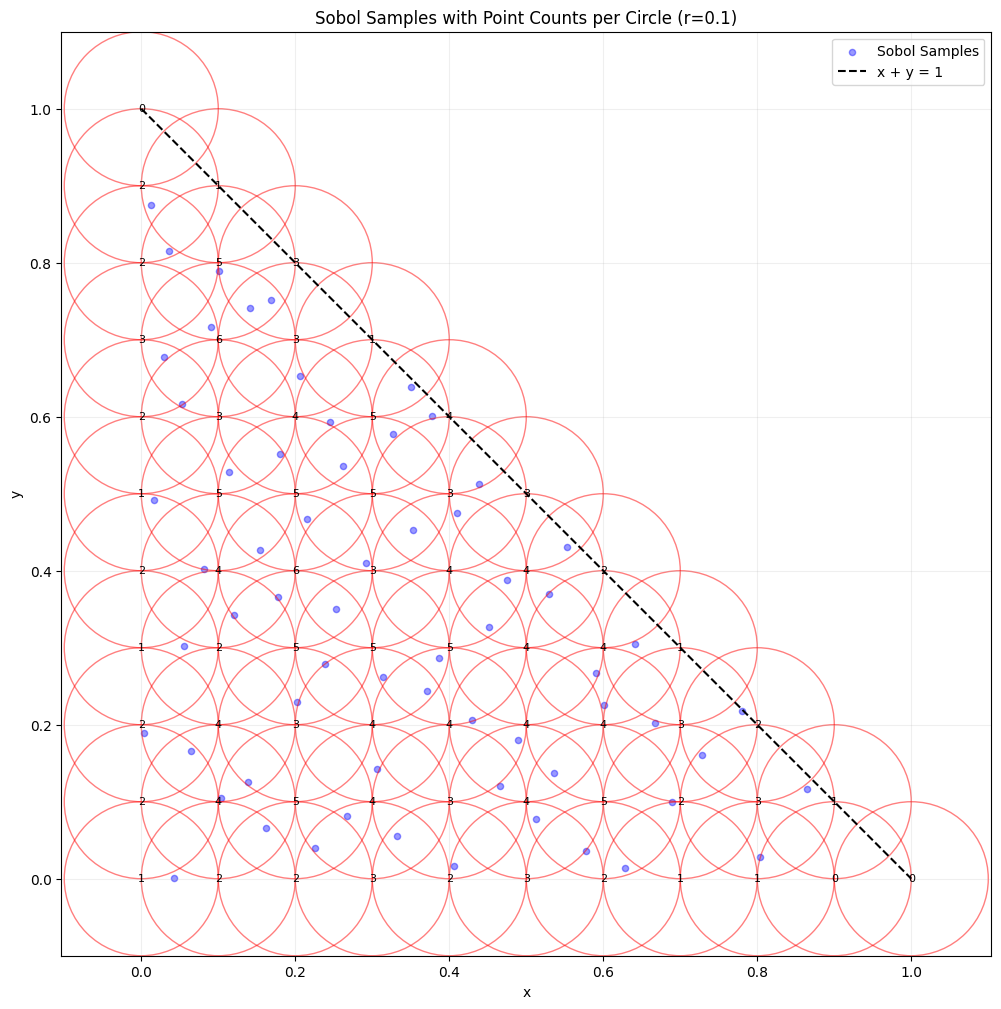

In [48]:
import numpy as np
from scipy.stats import qmc
import matplotlib.pyplot as plt

def generate_sobol_samples(n_samples, max_sum=1.0):
    """Generate Sobol samples within triangle where x + y <= 1"""
    sampler = qmc.Sobol(d=2, scramble=True)
    samples = sampler.random(n=n_samples * 2)
    samples *= max_sum
    valid_samples = samples[np.sum(samples, axis=1) <= max_sum]
    return valid_samples[:n_samples]

def create_circle_centers(spacing=0.1):
    """Create centers for circles in a grid pattern"""
    x = np.arange(0, 1.1, spacing)
    y = np.arange(0, 1.1, spacing)
    centers = []
    for i in x:
        for j in y:
            if i + j <= 1:
                centers.append([i, j])
    return np.array(centers)

def count_points_in_circles(samples, centers, radius):
    """Count number of samples within each circle"""
    counts = []
    for center in centers:
        # Calculate distances from center to all points
        distances = np.sqrt(np.sum((samples - center)**2, axis=1))
        # Count points within radius
        count = np.sum(distances <= radius)
        counts.append(count)
    return np.array(counts)

# Parameters
n_samples = 64
radius = 0.1
spacing = 0.1

# Generate samples and circle centers
samples = generate_sobol_samples(n_samples)
centers = create_circle_centers(spacing)

# Count points in each circle
counts = count_points_in_circles(samples, centers, radius)

# Create plot
plt.figure(figsize=(12, 12))

# Plot samples
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.4, label='Sobol Samples', color='blue', s=20)

# Plot circles and add count text
for center, count in zip(centers, counts):
    circle = plt.Circle(center, radius, fill=False, color='red', alpha=0.5)
    plt.gca().add_patch(circle)
    # Add count text slightly offset from center
    plt.text(center[0], center[1], str(count), 
             horizontalalignment='center', 
             verticalalignment='center',
             fontsize=8)

# Plot constraint line x + y = 1
x = np.linspace(0, 1, 100)
y = 1 - x
plt.plot(x, y, 'k--', label='x + y = 1')

# Print statistics
print(f"Total samples: {len(samples)}")
print(f"Number of circles: {len(centers)}")
print(f"Mean samples per circle: {np.mean(counts):.2f}")
print(f"Std samples per circle: {np.std(counts):.2f}")
print(f"Min samples per circle: {np.min(counts)}")
print(f"Max samples per circle: {np.max(counts)}")

plt.xlabel('x')
plt.ylabel('y')
plt.title('Sobol Samples with Point Counts per Circle (r=0.1)')
plt.legend()
plt.grid(True, alpha=0.2)
plt.axis('equal')
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 1.1)
plt.show()

In [49]:
counts

array([1, 2, 2, 1, 2, 1, 2, 3, 2, 2, 0, 2, 4, 4, 2, 4, 5, 3, 6, 5, 1, 2,
       5, 3, 5, 6, 5, 4, 3, 3, 3, 4, 4, 5, 3, 5, 5, 1, 2, 3, 4, 5, 4, 3,
       4, 3, 4, 4, 4, 4, 3, 2, 5, 4, 4, 2, 1, 2, 3, 1, 1, 3, 2, 0, 1, 0])

In [26]:
# group by mix 
results_by_dataset['fmnist_mnist']

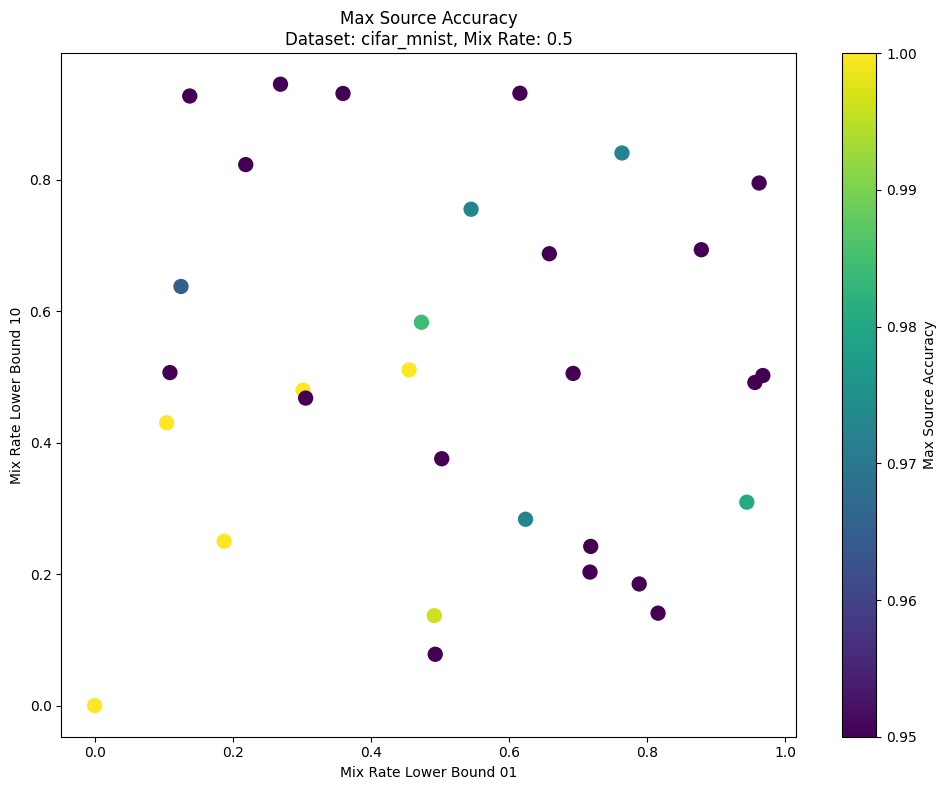

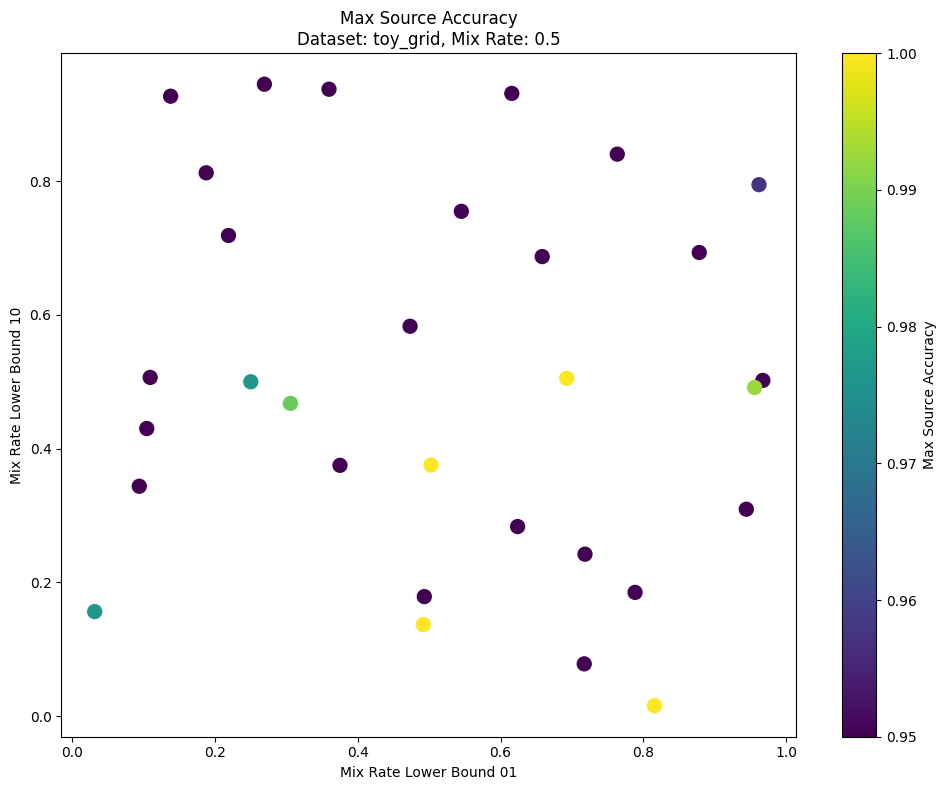

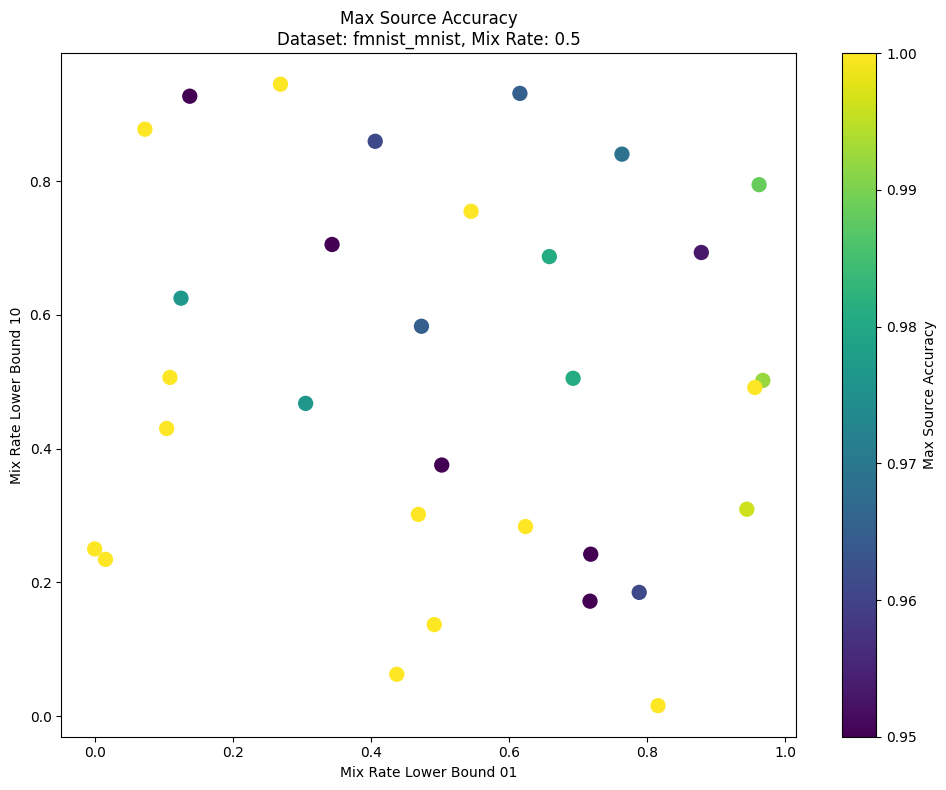

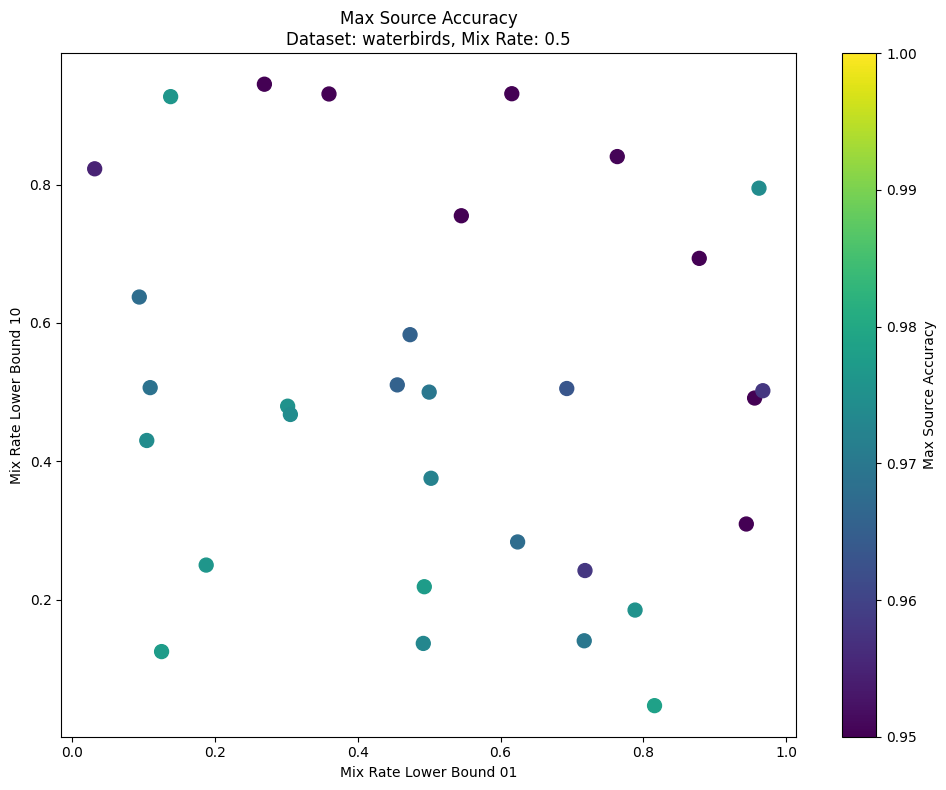

In [17]:
# Example usage:
mix_rate = 0.5
vmin = 0.95
vmax = 1.0
plot_mix_rate_accuracy(df, dataset='cifar_mnist', mix_rate=mix_rate, vmin=vmin, vmax=vmax)
plot_mix_rate_accuracy(df, dataset='toy_grid', mix_rate=mix_rate, vmin=vmin, vmax=vmax)
plot_mix_rate_accuracy(df, dataset='fmnist_mnist', mix_rate=mix_rate, vmin=vmin, vmax=vmax)
plot_mix_rate_accuracy(df, dataset='waterbirds', mix_rate=mix_rate, vmin=0.95, vmax=1.0)

## Correlation Between Source Acc and Target Acc

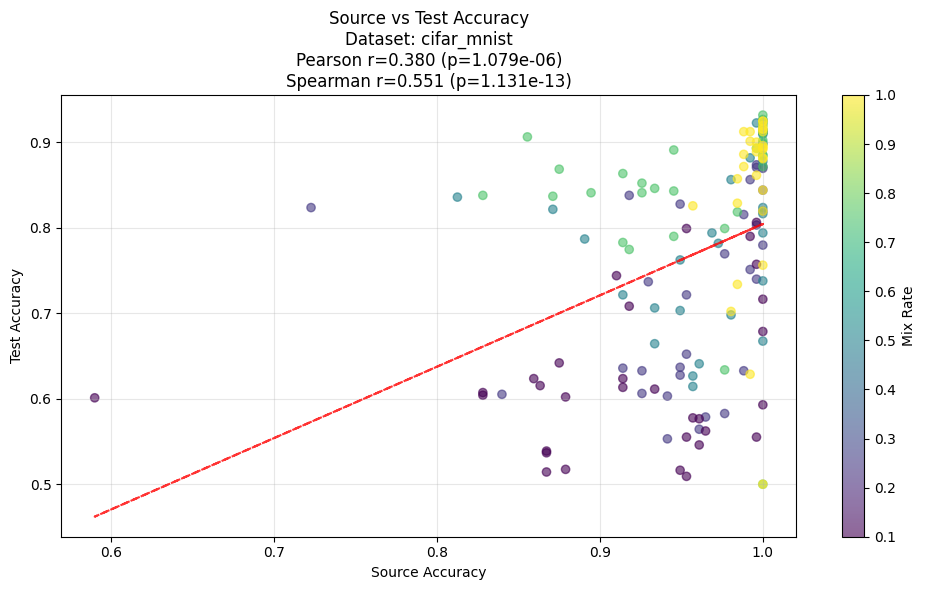

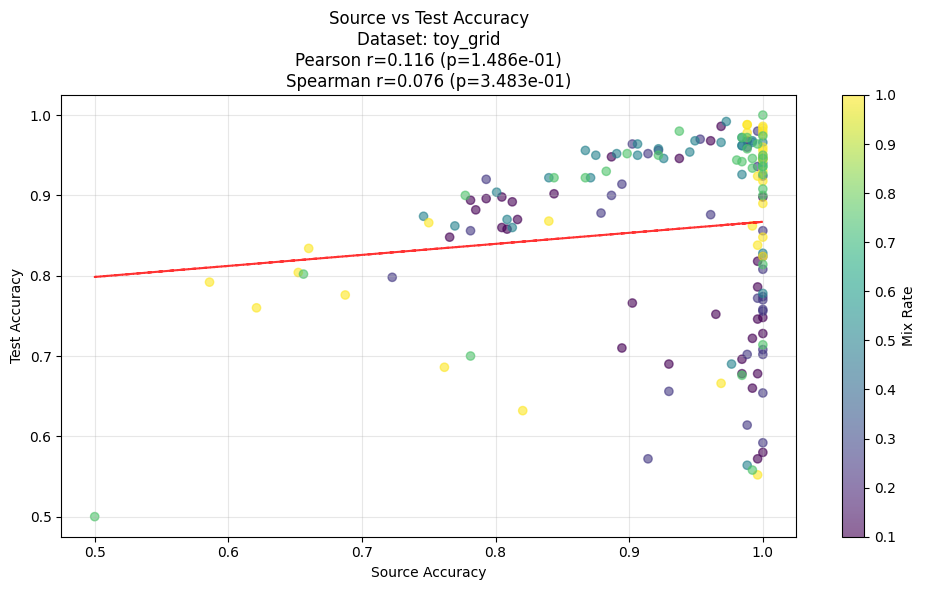

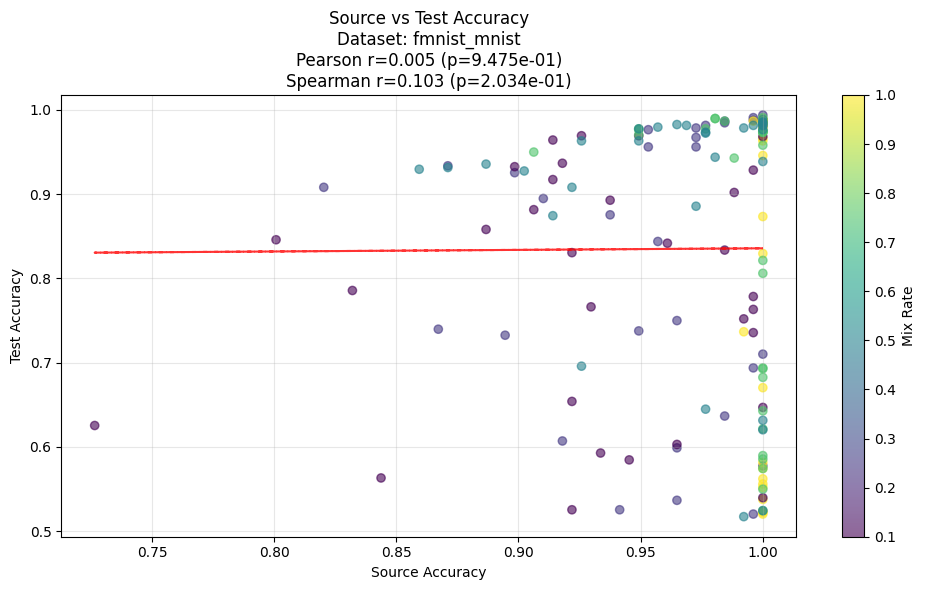

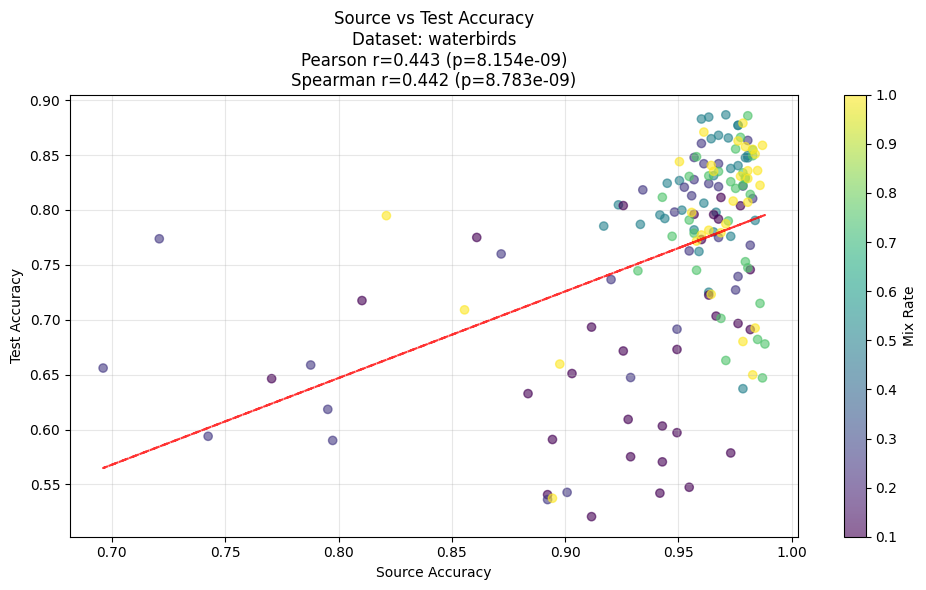

{'pearson_r': 0.4425227689084197,
 'pearson_p': 8.15403839341286e-09,
 'spearman_r': 0.44166133518732764,
 'spearman_p': 8.782573236154516e-09}

In [23]:
def analyze_source_target_correlation(df, dataset, mix_rate=None, figsize=(10, 6)):
    """
    Analyze and plot correlation between source and target accuracy for a given dataset.
    
    Args:
        df: DataFrame containing the results
        dataset: str, name of dataset to analyze
        mix_rate: float or None, if specified, filter for specific mix rate
        figsize: tuple, size of the figure (width, height)
    """
    import matplotlib.pyplot as plt
    from scipy import stats
    
    # Filter data
    mask = df['dataset'] == dataset
    if mix_rate is not None:
        mask = mask & (df['mix_rate'] == mix_rate)
    data = df[mask]
    
    if len(data) == 0:
        print(f"No data found for dataset={dataset}" + 
              (f" and mix_rate={mix_rate}" if mix_rate is not None else ""))
        return
    
    # Compute correlation
    pearson_r, p_value = stats.pearsonr(data['source_acc'], data['test_acc'])
    spearman_r, spearman_p = stats.spearmanr(data['source_acc'], data['test_acc'])
    
    # Create plot
    plt.figure(figsize=figsize)
    
    # Scatter plot with color based on mix rate
    scatter = plt.scatter(
        data['source_acc'],
        data['test_acc'],
        c=data['mix_rate'] if mix_rate is None else data['mix_rate_lb_01'],
        cmap='viridis',
        alpha=0.6
    )
    
    # Add colorbar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Mix Rate' if mix_rate is None else 'Mix Rate LB 01')
    
    # Add correlation line
    z = np.polyfit(data['source_acc'], data['test_acc'], 1)
    p = np.poly1d(z)
    plt.plot(data['source_acc'], p(data['source_acc']), "r--", alpha=0.8)
    
    # Labels and title
    plt.xlabel('Source Accuracy')
    plt.ylabel('Test Accuracy')
    title = f'Source vs Test Accuracy\nDataset: {dataset}'
    if mix_rate is not None:
        title += f'\nMix Rate: {mix_rate}'
    title += f'\nPearson r={pearson_r:.3f} (p={p_value:.3e})'
    title += f'\nSpearman r={spearman_r:.3f} (p={spearman_p:.3e})'
    plt.title(title)
    
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return {
        'pearson_r': pearson_r,
        'pearson_p': p_value,
        'spearman_r': spearman_r,
        'spearman_p': spearman_p
    }

# Example usage:
# For all mix rates:
analyze_source_target_correlation(df, dataset='cifar_mnist')
analyze_source_target_correlation(df, dataset='toy_grid')
analyze_source_target_correlation(df, dataset='fmnist_mnist')
analyze_source_target_correlation(df, dataset='waterbirds')

## Correlation Between Min(Mix Rate LB - Mix RATE, 0) and Source Acc

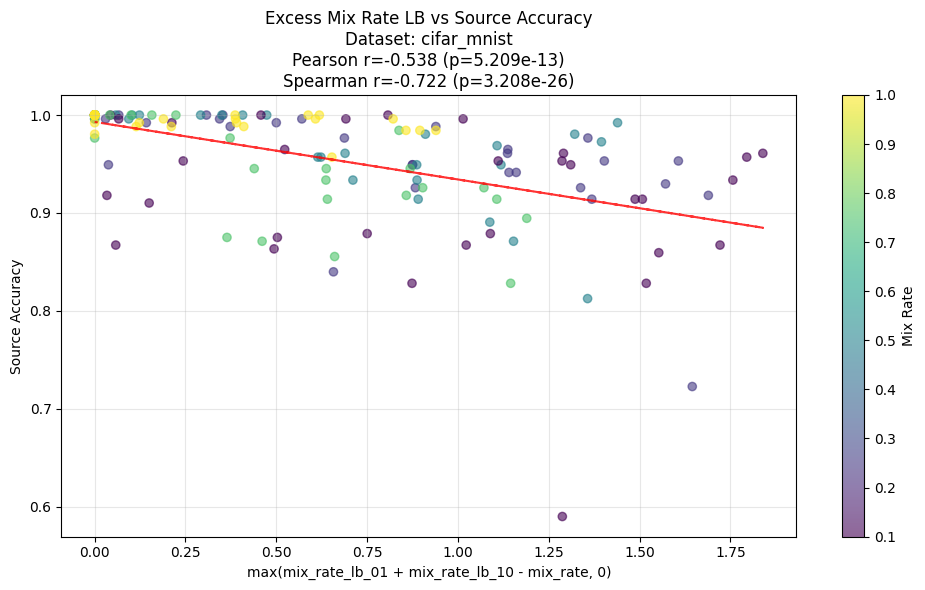

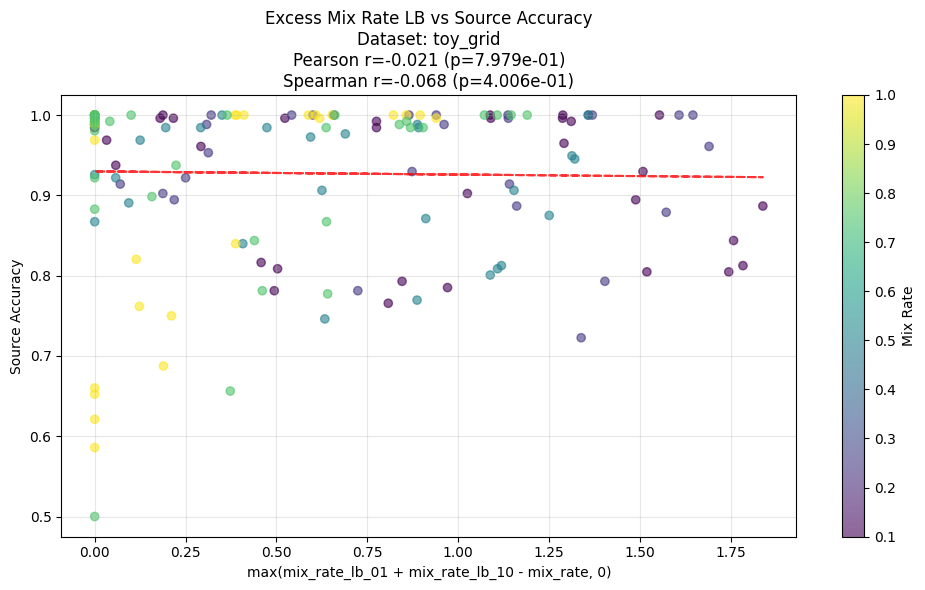

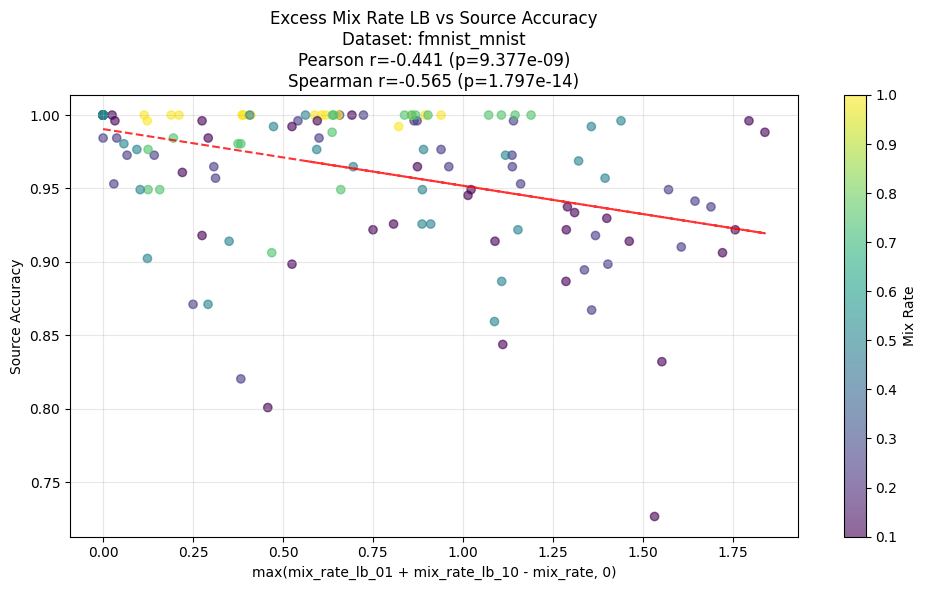

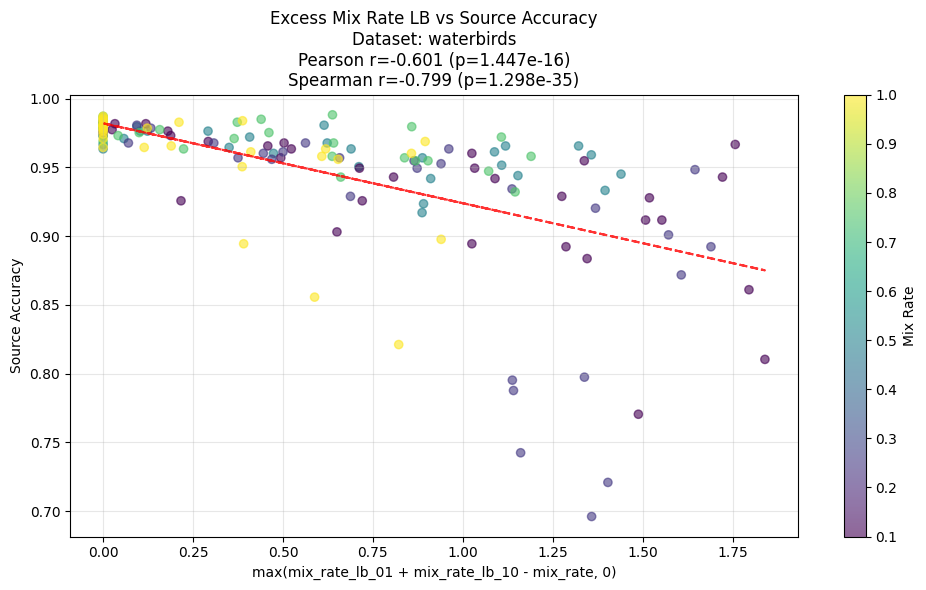

In [24]:
def analyze_mix_rate_lb_correlation(df, dataset, mix_rate=None, figsize=(10, 6)):
    """
    Analyze and plot correlation between excess mix rate lower bound and source accuracy.
    
    Args:
        df: DataFrame containing the results
        dataset: str, name of dataset to analyze
        mix_rate: float or None, if specified, filter for specific mix rate
        figsize: tuple, size of the figure (width, height)
    """
    import matplotlib.pyplot as plt
    from scipy import stats
    
    # Filter data
    mask = df['dataset'] == dataset
    if mix_rate is not None:
        mask = mask & (df['mix_rate'] == mix_rate)
    data = df[mask].copy()  # Create copy to avoid SettingWithCopyWarning
    
    if len(data) == 0:
        print(f"No data found for dataset={dataset}" + 
              (f" and mix_rate={mix_rate}" if mix_rate is not None else ""))
        return
    
    # Calculate excess mix rate lower bound
    data['excess_mix_rate_lb'] = np.maximum(
        data['mix_rate_lb_01'] + data['mix_rate_lb_10'] - data['mix_rate'],
        0
    )
    
    # Compute correlation
    pearson_r, p_value = stats.pearsonr(data['excess_mix_rate_lb'], data['source_acc'])
    spearman_r, spearman_p = stats.spearmanr(data['excess_mix_rate_lb'], data['source_acc'])
    
    # Create plot
    plt.figure(figsize=figsize)
    
    # Scatter plot
    scatter = plt.scatter(
        data['excess_mix_rate_lb'],
        data['source_acc'],
        c=data['mix_rate'],
        cmap='viridis',
        alpha=0.6
    )
    
    # Add colorbar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Mix Rate')
    
    # Add correlation line
    z = np.polyfit(data['excess_mix_rate_lb'], data['source_acc'], 1)
    p = np.poly1d(z)
    plt.plot(data['excess_mix_rate_lb'], p(data['excess_mix_rate_lb']), "r--", alpha=0.8)
    
    # Labels and title
    plt.xlabel('max(mix_rate_lb_01 + mix_rate_lb_10 - mix_rate, 0)')
    plt.ylabel('Source Accuracy')
    title = f'Excess Mix Rate LB vs Source Accuracy\nDataset: {dataset}'
    if mix_rate is not None:
        title += f'\nMix Rate: {mix_rate}'
    title += f'\nPearson r={pearson_r:.3f} (p={p_value:.3e})'
    title += f'\nSpearman r={spearman_r:.3f} (p={spearman_p:.3e})'
    plt.title(title)
    
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return {
        'pearson_r': pearson_r,
        'pearson_p': p_value,
        'spearman_r': spearman_r,
        'spearman_p': spearman_p
    }

# Example usage:
for dataset in ['cifar_mnist', 'toy_grid', 'fmnist_mnist', 'waterbirds']:
    analyze_mix_rate_lb_correlation(df, dataset=dataset)

# Sett

In [ ]:
# can I make this into a score? 

# no 


# ok just look else where for the mean,std erm 

# bin the mix rates into 10 bins 
# compute mean across bins for each dataset and mix rate 
# compute highest assumed mix rate within one standard deviation 
# 

In [ ]:
# so there's signal here, its just a matter of setting thresholds
# I think 